In [1]:
from Models.GAE import GAE
from Models.CAE import Autoencoder
import Models.Get_data as Gd
import torch
import torch.nn as nn
from kmeans_pytorch import kmeans
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA
import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

In [5]:
dataset, length = Gd.get_all_nodes(folders[:-1])
pca_trainset = dataset[:, :, 0]
print(pca_trainset.shape, folders[-1:])

(2900, 97149) ['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


In [6]:
train_set = np.expand_dims(pca_trainset, axis=2)
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.tensor(train_set, dtype=torch.float32))

In [7]:
preprocessor.mean

tensor(6.9571)

In [8]:
pca = PCA(n_components=25)
pca.fit(pca_trainset)
explained_variance_ratio = pca.explained_variance_ratio_
print("方差解释比例: \n", explained_variance_ratio, "\n")

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("累计方差解释比例: \n", cumulative_variance_ratio)

方差解释比例: 
 [0.59243554 0.11471574 0.0990813  0.04598222 0.04332158 0.02189648
 0.0139506  0.01023263 0.00932335 0.00769722 0.00613191 0.00486788
 0.00413865 0.0031495  0.00306014 0.00243276 0.00218207 0.00176031
 0.00155854 0.00136112] 

累计方差解释比例: 
 [0.59243554 0.70715128 0.80623258 0.85221479 0.89553637 0.91743285
 0.93138345 0.94161608 0.95093943 0.95863666 0.96476856 0.96963645
 0.97377509 0.9769246  0.97998474 0.9824175  0.98459957 0.98635988
 0.98791842 0.98927954]


# Get test data

In [9]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [10]:
sparse_graph = scipy.sparse.load_npz('/home/wl4023/data/Sibo_22Mar2024/sparse_matrix_fixed_weighted.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
distance = torch.norm(pos[edge_index[0]]-pos[edge_index[1]], dim=1)
edge_weight = 1/(distance)
edge_weight = edge_weight/torch.sum(edge_weight)*1000
edge_weight = edge_weight.unsqueeze(1)
print(f'{edge_weight.max():.8f}, {edge_weight.min():.8f}')

0.02281803, 0.00025737


In [11]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.MyDataset(test_tensor)

In [12]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


# Load model

In [13]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

## Load GAE_Kmeans

In [14]:
num_mp_layers = [2, 2, 2]
num_clusters = [1000, 25]
clusters = []
centroids = []

In [15]:
clusters = torch.load('/home/wl4023/github repos/IRP/result/Latent space 25/clusters.pt')
centroids = torch.load('/home/wl4023/github repos/IRP/result/Latent space 25/centroids.pt')

In [16]:
gae = GAE(1, 1, num_mp_layers, clusters, centroids, 16, 3)
criterion = RMSELoss()
metric = NRMSE(test_tensor)
# 加载保存的状态字典
state_dict = torch.load('/home/wl4023/github repos/IRP/result/Latent space 25/GAE_kmeans.pth')
gae.load_state_dict(state_dict)

<All keys matched successfully>

## Load CAE

In [17]:
cae = Autoencoder(1, 25)
# 加载保存的状态字典
state_dict = torch.load('/home/wl4023/github repos/IRP/result/Latent space 25/CAE.pth', map_location=torch.device('cpu'))
cae.load_state_dict(state_dict)
# model.to(device)

<All keys matched successfully>

# Prediction

In [18]:
criterion = RMSELoss()
metric = NRMSE(test_tensor)

## PCA

In [19]:
test_pca_set = test_np.squeeze()
# pca_testset = pca.transform(test_pca_set)
print(test_pca_set.shape)

pca_testset = []
for i in range(len(test_pca_set)):
    x = np.expand_dims(test_pca_set[i], axis=0)
    # print(pca.transform(x).shape)
    pca_testset.append(pca.transform(x))

pca_testset = np.concatenate(pca_testset, axis=0)

recon_pca_testset = torch.zeros_like(test_tensor)
PCA_RMSEs = []
PCA_NRMSEs = []

for i in range(len(test_tensor_set)):
    temp = pca.inverse_transform(pca_testset[i])
    recon_pca_testset[i] = torch.tensor(temp, dtype=torch.float).unsqueeze(1)

    rmse = criterion(test_tensor_set[i], recon_pca_testset[i]).item()
    nrmse = metric(test_tensor_set[i], recon_pca_testset[i]).item()

    PCA_RMSEs.append(rmse)
    PCA_NRMSEs.append(nrmse)

PCA_RMSEs = np.array(PCA_RMSEs)
PCA_NRMSEs = np.array(PCA_NRMSEs)

print(f"RMSE Loss: {PCA_RMSEs.mean()}, NRMSE Loss: {PCA_NRMSEs.mean()}")

(100, 97149)
RMSE Loss: 0.6839545917510986, NRMSE Loss: 0.03889472983777523


## GAE

In [20]:
gae.eval()
GAE_output = torch.zeros_like(test_tensor)
GAE_RMSEs = []
GAE_NRMSEs = []
with torch.no_grad():
    ave_rmse = 0
    ave_nrmse = 0
    for i in range(len(test_tensor)):
        input = preprocessor.transform(test_tensor[i])
        predict, _, _ = gae(input, edge_index, edge_weight, pos)
        GAE_output[i] = preprocessor.inverse_transform(predict)
        rmse = criterion(test_tensor[i], GAE_output[i]).item()
        nrmse = metric(test_tensor[i], GAE_output[i]).item()

        GAE_RMSEs.append(rmse)
        GAE_NRMSEs.append(nrmse)

        ave_rmse += rmse
        ave_nrmse += nrmse

ave_rmse /= len(test_tensor)
ave_nrmse /= len(test_tensor)


print(f"RMSE loss: {ave_rmse}")
print(f"NRMSE loss: {ave_nrmse}")

RMSE loss: 0.46197942048311236
NRMSE loss: 0.02627157561480999


## CAE

In [21]:
CAE_output = torch.zeros_like(test_tensor)
CAE_RMSEs = []
CAE_NRMSEs = []


for i in range(len(test_tensor_set)):
    x = preprocessor.transform(test_tensor_set[i]).permute(1, 0)

    output = cae(x)

    CAE_output[i] = preprocessor.inverse_transform(output.permute(0, 2, 1))

    rmse = criterion(test_tensor_set[i], CAE_output[i]).item()
    nrmse = metric(test_tensor_set[i], CAE_output[i]).item()

    CAE_RMSEs.append(rmse)
    CAE_NRMSEs.append(nrmse)

CAE_RMSEs = np.array(CAE_RMSEs)
CAE_NRMSEs = np.array(CAE_NRMSEs)

print(f"RMSE Loss: {CAE_RMSEs.mean()}, NRMSE Loss: {CAE_NRMSEs.mean()}")

RMSE Loss: 0.9416652256250382, NRMSE Loss: 0.05355006761848927


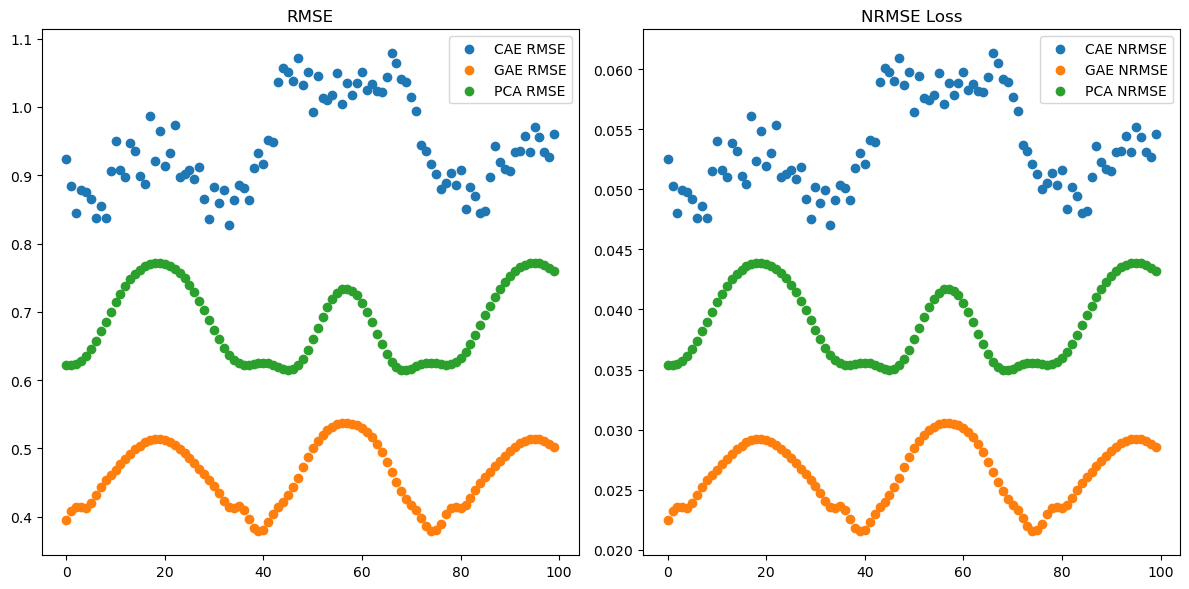

In [22]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100)

axs[0].scatter(x, CAE_RMSEs, label='CAE RMSE')
axs[0].scatter(x, GAE_RMSEs, label='GAE RMSE')
axs[0].scatter(x, PCA_RMSEs, label='PCA RMSE')
axs[0].set_title("RMSE")
axs[0].legend()

axs[1].scatter(x, CAE_NRMSEs, label='CAE NRMSE')
axs[1].scatter(x, GAE_NRMSEs, label='GAE NRMSE')
axs[1].scatter(x, PCA_NRMSEs, label='PCA NRMSE')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.show()

In [23]:
def draw_pic(x, pca_data, gae_data, cae_data, coords):

    vmin = min(np.min(x), np.min(pca_data), np.min(gae_data), np.min(cae_data))
    vmax = max(np.max(x), np.max(pca_data), np.max(gae_data), np.max(cae_data))

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    
    
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('original')
    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=pca_data[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('PCA')
    fig2.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig3, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=gae_data[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('GAE')
    fig3.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig4, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=cae_data[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('CAE')
    fig4.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

In [24]:
def draw_pic(x, pca_data, gae_data, cae_data, coords):

    vmin = min(np.min(x), np.min(pca_data), np.min(gae_data), np.min(cae_data))
    vmax = max(np.max(x), np.max(pca_data), np.max(gae_data), np.max(cae_data))

    fig1, axs = plt.subplots(4, 5, figsize=(30, 24), sharey=True)
    
    
    for i in range(5):
        im = axs[0][i].scatter(coords[:, 0], coords[:, 1], s=5, c=x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[0][i].set_title('original')



    for i in range(5):
        im = axs[1][i].scatter(coords[:, 0], coords[:, 1], s=5, c=pca_data[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[1][i].set_title('PCA')



    for i in range(5):
        im = axs[2][i].scatter(coords[:, 0], coords[:, 1], s=5, c=gae_data[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[2][i].set_title('GAE')



    for i in range(5):
        im = axs[3][i].scatter(coords[:, 0], coords[:, 1], s=5, c=cae_data[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[3][i].set_title('CAE')


    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

In [25]:
x = test_tensor[60:65].detach().numpy()
pca_data = recon_pca_testset[60:65].detach().numpy()
gae_data = GAE_output[60:65].detach().numpy()
cae_data = CAE_output[60:65].detach().numpy()
coords = np.load(xyfile)

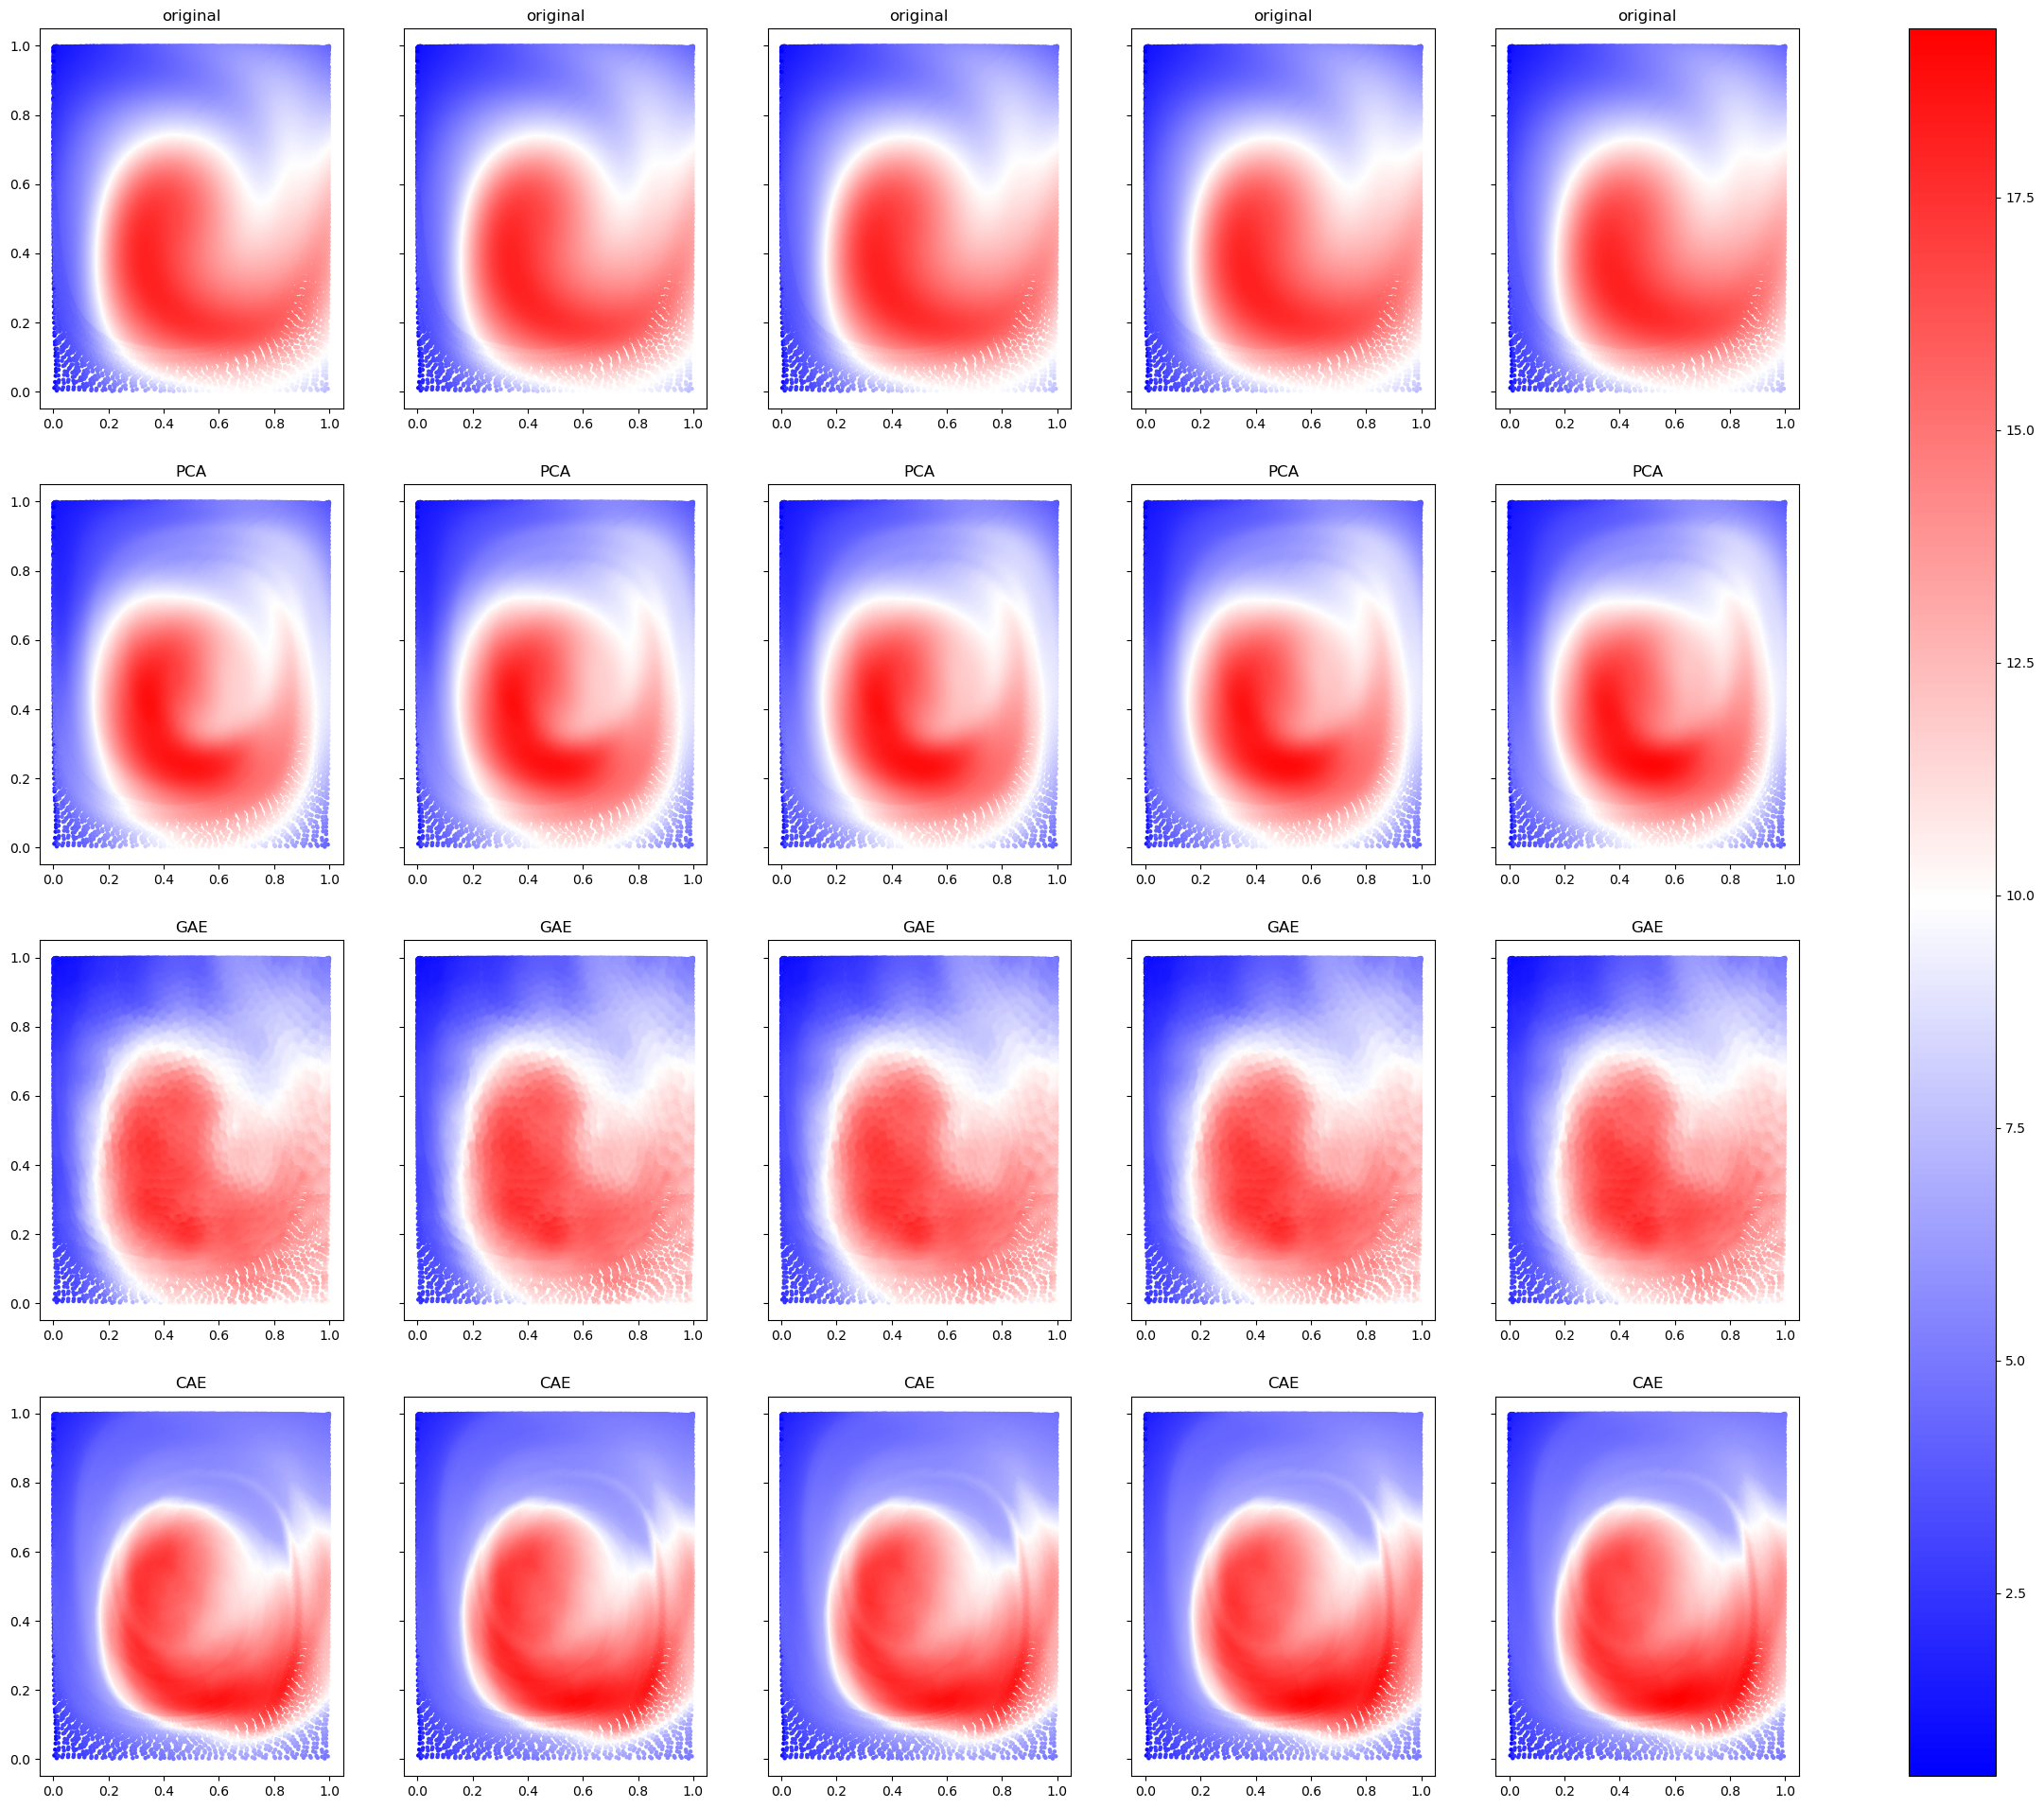

In [26]:
draw_pic(x, pca_data, gae_data, cae_data, coords=pos)